Libraries

In [2]:
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
from sklearn.metrics import mean_squared_log_error
from statsmodels.stats.stattools import durbin_watson
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.diagnostic import het_breuschpagan
from pygam import LinearGAM, s, f
import scipy.stats as stats

Loading Data

In [3]:
TRAIN = pd.read_csv("aba_train.csv")

TEST = pd.read_csv("aba_test.csv")

# One hot encoding Sex variable
TRAIN_NEW = pd.get_dummies(TRAIN, columns=['Sex'], drop_first=True)
TRAIN_NEW[['Sex_M', 'Sex_I']] = TRAIN_NEW[['Sex_M', 'Sex_I']].astype(int)

TEST_NEW = pd.get_dummies(TEST, columns=['Sex'], drop_first=True)
TEST_NEW[['Sex_M', 'Sex_I']] = TEST_NEW[['Sex_M', 'Sex_I']].astype(int)

print(TRAIN_NEW.shape)
print(TEST_NEW.shape)



(90615, 11)
(60411, 10)


Fitting a Polynomial Regression

This model is the multiple linear model from assignment 2 that adressed multicollinearity by removing predictors one-by-one based on highest VIF values

In [4]:
#This was the model from assignment 2 with reduced multicollinearity

X = TRAIN_NEW[['Shell weight', 'Height', 'Whole weight.1',
               'Sex_M', 'Sex_I']].values
y=TRAIN_NEW[['Rings']].values

X = sm.add_constant(X)  
model1 = sm.OLS(y, X).fit()
print(model1.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.597
Model:                            OLS   Adj. R-squared:                  0.597
Method:                 Least Squares   F-statistic:                 2.688e+04
Date:                Sun, 23 Mar 2025   Prob (F-statistic):               0.00
Time:                        03:40:24   Log-Likelihood:            -1.9209e+05
No. Observations:               90615   AIC:                         3.842e+05
Df Residuals:                   90609   BIC:                         3.842e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.7081      0.043    110.407      0.0

Using the reduced multicollinearity model from assignment 2, each numeric variable (shell weight, height, and whole weight.1) will be squared or a polynomial of degree 2. 

Polynomial Regression Equation:
Rings = 3.8568 + 44.8711 * Shell weight + 29.8549 * Height + -20.0464 * Whole weight.1 + -26.2907 * Shell weight^2 + -28.0372 * Height^2 + 6.5069 * Whole weight.1^2 + -0.0024 * Sex_M + -0.5301 * Sex_I

R-square = 61.3%

In [5]:
# Selecting features
numeric_features = ['Shell weight', 'Height', 'Whole weight.1']
categorical_features = ['Sex_M', 'Sex_I']
target = 'Rings'

# Creating polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
X_poly_full = poly.fit_transform(TRAIN_NEW[numeric_features])

# Getting variable names 
feature_names = poly.get_feature_names_out(numeric_features)

# Select variables and squared variables (no interactions)
selected_features = [name for name in feature_names if '^' in name or name in numeric_features]
X_poly_selected = TRAIN_NEW[numeric_features].copy()

# Adding squared variables
for feature in numeric_features:
    X_poly_selected[f"{feature}^2"] = TRAIN_NEW[feature] ** 2

X_poly_final = np.hstack((X_poly_selected.values, TRAIN_NEW[categorical_features].values))

# Adding constant 
X_poly_final = sm.add_constant(X_poly_final)
y = TRAIN_NEW[target].values

# Fitting model
model = sm.OLS(y, X_poly_final).fit()

print(model.summary())

# Creating equation
coefficients = model.params

all_feature_names = ['const'] + list(X_poly_selected.columns) + categorical_features

const = coefficients[0]
equation_terms = [f"{coeff:.4f} * {name}" for coeff, name in zip(coefficients[1:], all_feature_names[1:])]

equation = f"Rings = {const:.4f} + " + " + ".join(equation_terms)

print()
print()
print("Polynomial Regression Equation:")
print(equation)






                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                 1.796e+04
Date:                Sun, 23 Mar 2025   Prob (F-statistic):               0.00
Time:                        03:40:29   Log-Likelihood:            -1.9025e+05
No. Observations:               90615   AIC:                         3.805e+05
Df Residuals:                   90606   BIC:                         3.806e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8568      0.052     74.045      0.0

Polynomial model RMSLE = 0.149

In [6]:
# Predictions
y_pred = model.predict(X_poly_final)

# All positives and no logs of 0
y_pred = np.maximum(y_pred, 0) 
y_pred = y_pred + 1  
y_actual = y + 1  

# RMSLE calculation
rmsle = np.sqrt(mean_squared_log_error(y_actual, y_pred))

print(f"RMSLE: {rmsle:.4f}")


RMSLE: 0.1490


Justification for adding second degree polynomial terms (squared terms):

Shell weight: in the scatter plot for shell weight vs rings we see that the highest ring values appear to be between 0.2 and 0.5, and they seem to drop at shell weights greater than 0.6. This is exactly what our model is predicting basically the shell weight^2 value is saying at higher values of shell weight the rate of increase in rings slows and eventually decreases. 

Height: The scatter plot for height vs rings has a similar trend like shell weight. We see the highest ring values between heights of 0.1 and 0.2. With a sharp decrease of rings at higher heights.

Whole weight.1: Whole weight.1 vs rings shows the same trend as shell weight as well. We see highest ring values between weights of 0.2 and 0.6. Then these ring values start to decrease for whole weights greater than 0.8.

Checking Assumptions:

Dependent and Independent Variables can be modeled with a polynomial function: PASSED see above justifications 

Independence of Errors: PASSED Not time order or sequential data and DW stat of 2 suggests independent observations

Constant Variance: FAILED Residual vs fitted shows a cluster above 0 and below 0 "red line". Also, bp test gives very low pvalue suggesting we reject null hypothesis that data is homoscedastic

Normality of residuals: FAILED Violated residuals deviate from normal line

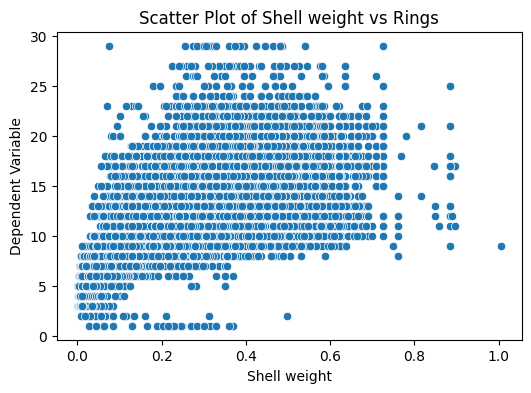

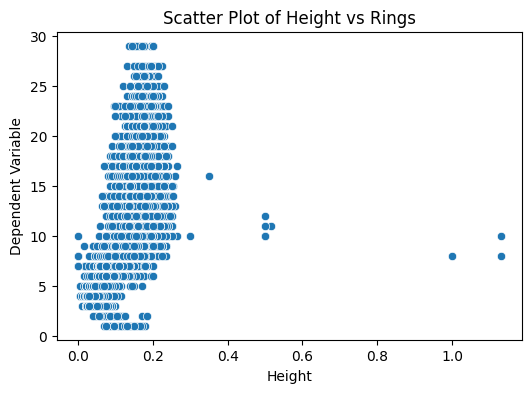

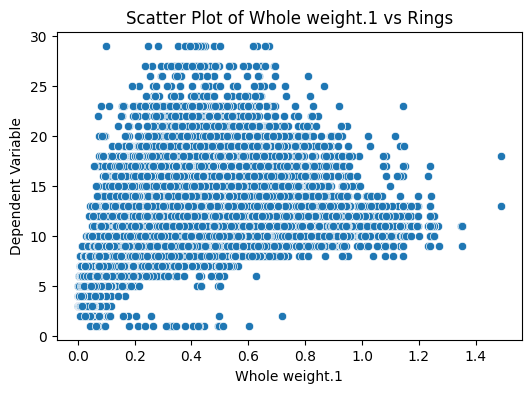

Durbin-Watson Statistic: 1.9984


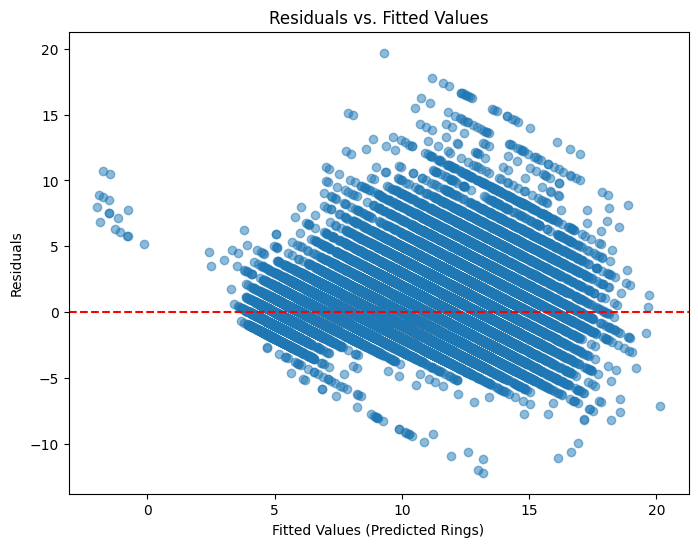

Breusch-Pagan p-value: 0.0000


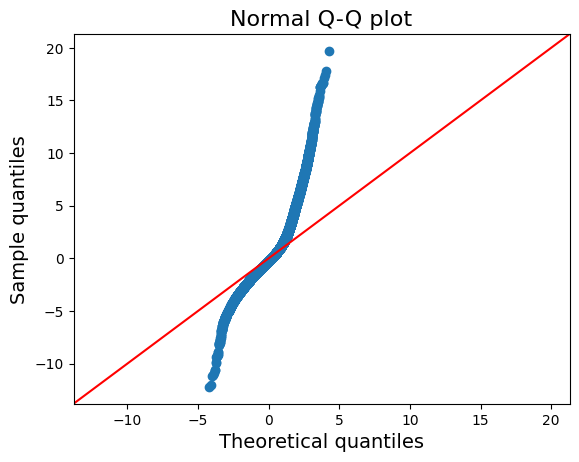

In [7]:
X = TRAIN_NEW[['Shell weight', 'Height', 'Whole weight.1']]  
y = TRAIN_NEW['Rings']

# Scatter plots showing poly trends
for col in X.columns:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=TRAIN_NEW[col], y=y)
    plt.xlabel(col)
    plt.ylabel('Dependent Variable')
    plt.title(f'Scatter Plot of {col} vs Rings')
    plt.show()

#independence of errors
residuals = model.resid  

# Durbin-Watson statistic
dw_statistic = durbin_watson(residuals)

print(f"Durbin-Watson Statistic: {dw_statistic:.4f}")


# Residual vs fitted
fitted_values = model.fittedvalues  

# Residuals
residuals = model.resid 

# Create the residual vs. fitted plot
plt.figure(figsize=(8,6))
plt.scatter(fitted_values, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--') 
plt.xlabel('Fitted Values (Predicted Rings)')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.show()

#shows reject the null that data has equal variance or homoscedastic 
bp_test = het_breuschpagan(model.resid, model.model.exog)
print(f"Breusch-Pagan p-value: {bp_test[1]:.4f}")


#QQ-plot for Residuals
p=sm.qqplot(residuals,line='45')
plt.title('Normal Q-Q plot', fontsize=16);
plt.xlabel('Theoretical quantiles', fontsize=14);
plt.ylabel('Sample quantiles', fontsize=14);



Making predictions with the Polynomial model

In [8]:
numeric_features = ['Shell weight', 'Height', 'Whole weight.1']
categorical_features = ['Sex_M', 'Sex_I']

X_test_numeric = TEST_NEW[numeric_features].values  
X_test_categorical = TEST_NEW[categorical_features].values 

poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)  
X_test_poly_numeric = poly.fit_transform(X_test_numeric)  

# Remove interactions
X_test_poly_selected = TEST_NEW[numeric_features].copy()

for feature in numeric_features:
    X_test_poly_selected[f"{feature}^2"] = TEST_NEW[feature] ** 2

X_test_poly_final = np.hstack((X_test_poly_selected.values, X_test_categorical))

X_test_poly_final = sm.add_constant(X_test_poly_final)

# New rings column
TEST_NEW['Rings'] = np.maximum(model.predict(X_test_poly_final).round().astype(int), 0)

print(TEST_NEW.head())

# Creation of equation to ensure matches trained model 
coefficients = model.params

all_feature_names = ['const'] + numeric_features + [f"{feature}^2" for feature in numeric_features] + categorical_features

const = coefficients[0]
equation_terms = [f"{coeff:.4f} * {name}" for coeff, name in zip(coefficients[1:], all_feature_names[1:])]

equation = f"Rings = {const:.4f} + " + " + ".join(equation_terms)

print("\nPolynomial Regression Equation:")
print(equation)


# Creates Poly model prediction submission for kaggle
#TEST_NEW = TEST_NEW.iloc[:, [0, -1]]  # Keep only ID and predicted Rings
#TEST_NEW.to_csv("abalone_submission_polymodel.csv", index=False)




      id  Length  Diameter  Height  Whole weight  Whole weight.1  \
0  90615   0.645     0.475   0.155        1.2380          0.6185   
1  90616   0.580     0.460   0.160        0.9830          0.4785   
2  90617   0.560     0.420   0.140        0.8395          0.3525   
3  90618   0.570     0.490   0.145        0.8740          0.3525   
4  90619   0.415     0.325   0.110        0.3580          0.1575   

   Whole weight.2  Shell weight  Sex_I  Sex_M  Rings  
0          0.3125        0.3005      0      1      9  
1          0.2195        0.2750      0      1     10  
2          0.1845        0.2405      0      1     10  
3          0.1865        0.2350      0      1     10  
4          0.0670        0.1050      1      0      8  

Polynomial Regression Equation:
Rings = 3.8568 + 44.8711 * Shell weight + 29.8549 * Height + -20.0464 * Whole weight.1 + -26.2907 * Shell weight^2 + -28.0372 * Height^2 + 6.5069 * Whole weight.1^2 + -0.0024 * Sex_M + -0.5301 * Sex_I


New Model Creation: Generalized Additive Model

In [9]:
# Only to ensure new model starts with original data
TRAIN = pd.read_csv("aba_train.csv")

TEST = pd.read_csv("aba_test.csv")

# One hot encoding Sex variable
TRAIN_NEW = pd.get_dummies(TRAIN, columns=['Sex'], drop_first=True)
TRAIN_NEW[['Sex_M', 'Sex_I']] = TRAIN_NEW[['Sex_M', 'Sex_I']].astype(int)

TEST_NEW = pd.get_dummies(TEST, columns=['Sex'], drop_first=True)
TEST_NEW[['Sex_M', 'Sex_I']] = TEST_NEW[['Sex_M', 'Sex_I']].astype(int)

print(TRAIN_NEW.shape)
print(TEST_NEW.shape)

(90615, 11)
(60411, 10)


GAM Creation

We see smoothness in the partial dependence plots for all numeric variables.

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     41.3393
Link Function:                     IdentityLink Log Likelihood:                                -217049.839
Number of Samples:                        90615 AIC:                                           434184.3566
                                                AICc:                                          434184.3971
                                                GCV:                                                3.8464
                                                Scale:                                              3.8433
                                                Pseudo R-Squared:                                   0.6192
Feature Function                  Lam

C:\Users\jacob\AppData\Local\Temp\ipykernel_61924\3958203302.py:13: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


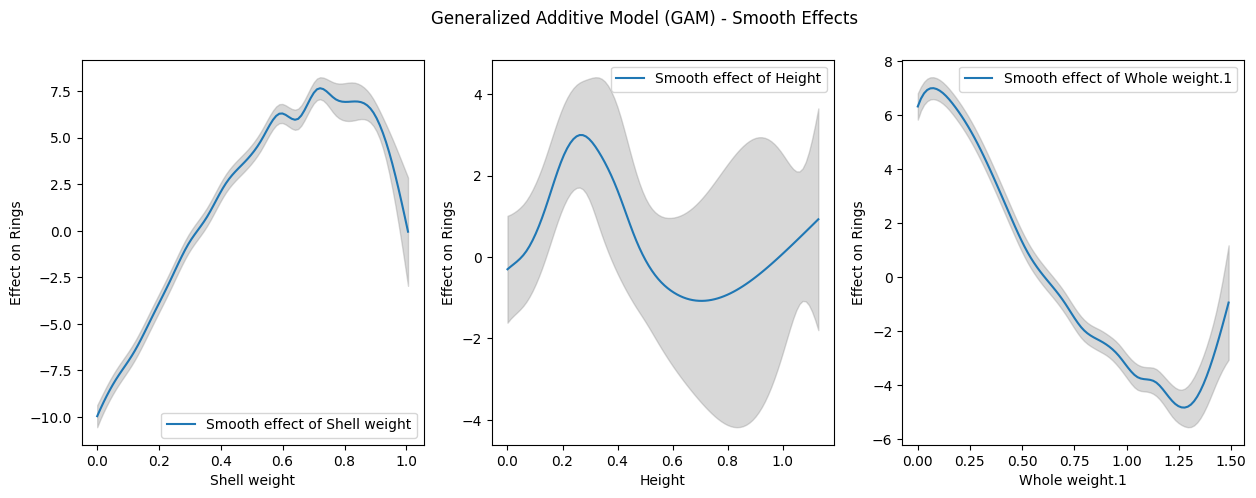

In [10]:
X = TRAIN_NEW[['Shell weight', 'Height', 'Whole weight.1', 'Sex_M', 'Sex_I']].values
y = TRAIN_NEW[['Rings']].values.ravel()  # Convert to 1D array

# GAM model 
gam = LinearGAM(
    s(0) +  # Function for Shell weight
    s(1) +  # Function for Height
    s(2) +  # Function for Whole weight.1
    f(3) +  # Factor term for Sex_M
    f(4)    # Factor term for Sex_I
).fit(X, y)

print(gam.summary())

# Visualize functions
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, term in enumerate(["Shell weight", "Height", "Whole weight.1"]):
    XX = np.linspace(X[:, i].min(), X[:, i].max(), 100).reshape(-1, 1)  
    
    X_pred = np.tile(X.mean(axis=0), (100, 1))
    X_pred[:, i] = XX.ravel() 
    
    pdep, conf_int = gam.partial_dependence(term=i, X=X_pred, width=0.95)

    lower, upper = conf_int.T  

    axs[i].plot(XX, pdep, label=f'Smooth effect of {term}')
    axs[i].fill_between(XX.ravel(), lower, upper, alpha=0.3, color='gray')  
    axs[i].set_xlabel(term)
    axs[i].set_ylabel("Effect on Rings")
    axs[i].legend()

plt.suptitle("Generalized Additive Model (GAM) - Smooth Effects")
plt.show()

GAM Assumptions:

Independent observations: Passed. Durbin watson of 2 suggest independent observations our DW = 1.997

Linearity of smooth terms: Passed. Predictors partial dependence plots exhibit smooth trend lines. Or not too "wiggly".

Constant Variance: Failed. Residual vs fitted plots shows a cluster pattern, but to be sure the BP test is performed and the small p-value suggest that the null hypothesis that variance of residuals is constant should be rejected. 

Normality of Residuals: Failed. Residuals do not follow normal line "red line". Drastic deviation at theoretical quantiles below -4 and above 2.

Durbin-Watson statistic: 1.9977


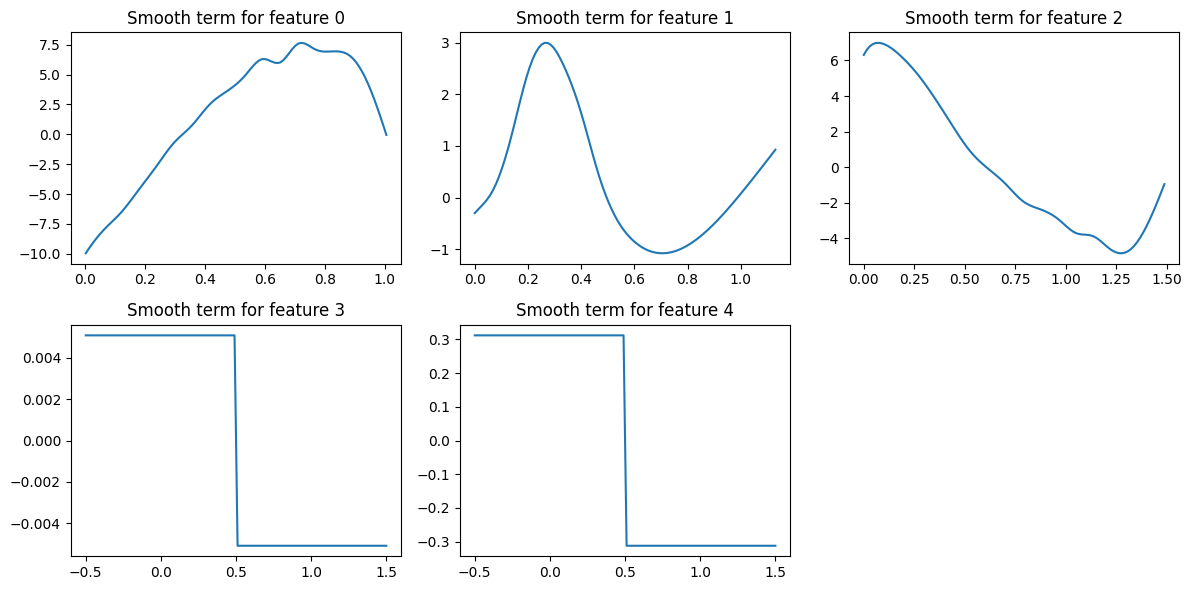

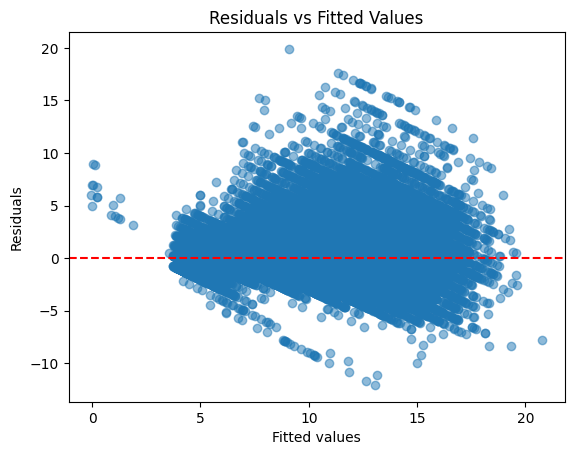

{'LM Statistic': 6401.4759442009845, 'LM-Test p-value': 0.0, 'F-Statistic': 1377.5253804692563, 'F-Test p-value': 0.0}


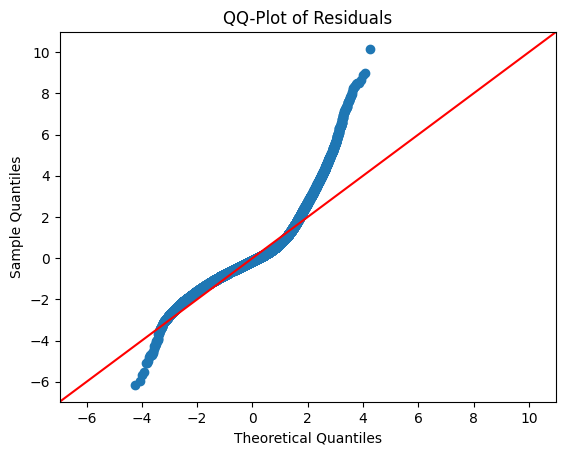

In [11]:
#independence test
# Residuals
residuals = y - gam.predict(X)

# Durbin-Watson statistic
dw_stat = durbin_watson(residuals)
print(f"Durbin-Watson statistic: {dw_stat:.4f}")

#linearity of smooth terms
#patterns look smooth and not too wiggly
plt.figure(figsize=(12, 6))

plot_idx = 1  
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    plt.subplot(2, 3, plot_idx)
    XX = gam.generate_X_grid(term=i)
    plt.plot(XX[:, term.feature], gam.partial_dependence(term=i, X=XX))
    plt.title(f'Smooth term for feature {i}')
    plot_idx += 1

plt.tight_layout()
plt.show()


#Constant variance
fitted_vals = gam.predict(X)
residuals = y - fitted_vals

plt.scatter(fitted_vals, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.show()

#Bp test
X_bp = sm.add_constant(X)

# BP test with low p-vals so reject null of equal variance
bp_test = het_breuschpagan(residuals, X_bp)
bp_labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
print(dict(zip(bp_labels, bp_test)))



#normal residuals
sm.qqplot(residuals, line='45', fit=True)
plt.title("QQ-Plot of Residuals")
plt.show()






GAM RMSLE = 0.1613

In [12]:
# Calculate RMSLE
y_pred = gam.predict(X)

y_pred = np.clip(y_pred, 0, None)  

rmsle = np.sqrt(mean_squared_log_error(y, y_pred))

print(f"RMSLE: {rmsle:.4f}")

RMSLE: 0.1613


Evaluation of Splines and Factor Data Coefficients and Different Method of Partial Dependence Plots with Focus on Confidence.

Intercept: 7.75467422523155
Sex_M coefficient: 0.0050772995779949275
Sex_I coefficient: 0.3121156260921722

Term 0 (spline_term): Coef indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Coefficients: [-1.24390425e+01 -9.85265166e+00 -7.91105473e+00 -6.68479246e+00
 -4.60517396e+00 -2.72563318e+00 -4.92645524e-01  5.52033086e-01
  2.69952884e+00  3.58617108e+00  4.71394138e+00  6.97730361e+00
  5.18749639e+00  8.37962790e+00  6.79450501e+00  6.99470752e+00
  6.89214574e+00  4.43702644e+00  5.80138505e-03 -4.75475453e+00]
Term 1 (spline_term): Coef indices: [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
Coefficients: [-0.79954349 -0.25153838 -0.00415352  1.00548756  2.56935122  3.19593049
  2.62993583  1.7367591   0.35685783 -0.4705277  -0.88103475 -1.07715408
 -1.09045505 -0.95250698 -0.69487917 -0.34914088  0.05313863  0.48322968
  0.92537524  1.36952982]
Term 2 (spline_term): Coef indices: [40, 41, 42, 43, 44, 45, 46, 47, 

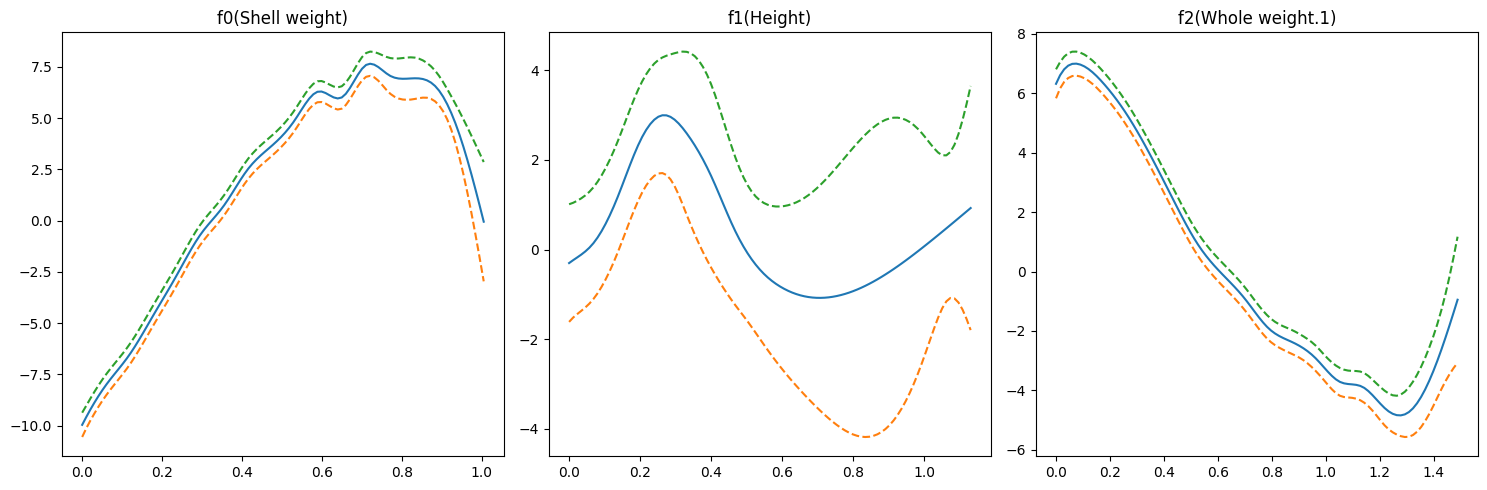

In [13]:
intercept = gam.coef_[64]
print(f"Intercept: {intercept}")

sex_m_coeff = gam.coef_[60]
sex_i_coeff = gam.coef_[62]
print(f"Sex_M coefficient: {sex_m_coeff}")
print(f"Sex_I coefficient: {sex_i_coeff}")

print()

for i, term in enumerate(gam.terms):
    idx = gam.terms.get_coef_indices(i) 
    print(f"Term {i} ({term}): Coef indices: {idx}")
    print(f"Coefficients: {gam.coef_[idx]}")



fig, axs = plt.subplots(1, 3, figsize=(15, 5))
titles = ['Shell weight', 'Height', 'Whole weight.1']

for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)
    ax.plot(XX[:, i], pdep)
    ax.plot(XX[:, i], confi[:, 0], ls='--')
    ax.plot(XX[:, i], confi[:, 1], ls='--')
    ax.set_title(f'f{i}({titles[i]})')
plt.tight_layout()
plt.show()


Using GAM To Make Test Predictions

In [14]:
X_test = TEST_NEW[['Shell weight', 'Height', 'Whole weight.1', 'Sex_M', 'Sex_I']].values

predictions = np.maximum(gam.predict(X_test).round().astype(int), 0)

TEST_NEW['Rings'] = predictions

print(TEST_NEW.head())

# Generation of Kaggle prediction submission
#TEST_NEW = TEST_NEW.iloc[:, [0, -1]]  
#TEST_NEW.to_csv("abalone_submission_GAMmodel.csv", index=False)


      id  Length  Diameter  Height  Whole weight  Whole weight.1  \
0  90615   0.645     0.475   0.155        1.2380          0.6185   
1  90616   0.580     0.460   0.160        0.9830          0.4785   
2  90617   0.560     0.420   0.140        0.8395          0.3525   
3  90618   0.570     0.490   0.145        0.8740          0.3525   
4  90619   0.415     0.325   0.110        0.3580          0.1575   

   Whole weight.2  Shell weight  Sex_I  Sex_M  Rings  
0          0.3125        0.3005      0      1      9  
1          0.2195        0.2750      0      1     10  
2          0.1845        0.2405      0      1     11  
3          0.1865        0.2350      0      1     11  
4          0.0670        0.1050      1      0      8  


Note that R-squares and TEST DATA RMSLEs, provided after kaggle competition submission of polynomial model and GAM, are extremely similar. Therefore, parsimony suggests that we prefer the polynomial model as it is simpler.

Polynomial:

R-squared = 61.3%

Training RMSLE = 0.149

Testing RMSLE "Provided by Kaggle Upon Submission" = 0.167

GAM:

R-squared = 61.9%

Training RMSLE = 0.161

Testing RMSLE "Provided by Kaggle Upon Submission" = 0.163